In [21]:
import qiskit as qk
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile
from qiskit.visualization import plot_histogram
from math import pi
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
import pandas as pd
import numpy as np
import random
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from time import time
from qiskit.circuit.library.standard_gates import RYGate, RYYGate

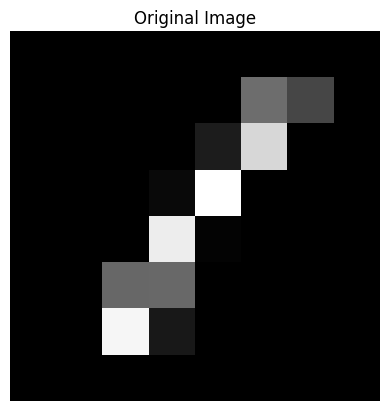

In [22]:
# Read the CSV file. 
# (Assuming the CSV has a label in the first column and pixel values in the remaining 64 columns, for an 8x8 image.)
dataset = pd.read_csv('../frqi/website/static/mnist_dataset.csv')

# Select the first image, ignoring the label column.
# Adjust slicing if your file has a different format.
image_data = dataset.to_numpy()[0, 1:]
# Reshape to an 8x8 array and ensure pixel values are integers (0-255)
image = image_data.reshape(8, 8).astype(np.uint8)

plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [23]:
# Normalize pixel values to 8-bit integers (0-255)
pixel_values = image.flatten()

# Declare the Quantum and Classical registers
position_qubits = QuantumRegister(6, 'pos')  # 6 qubits for 64 positions
intensity_qubits = QuantumRegister(8, 'int')  # 8 qubits for intensity (8-bit grayscale)
classical_bits = ClassicalRegister(14, 'c')  # For measurement
qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)

# Function to apply Hadamard gates to position qubits
def hadamard(circ, n):
    for i in n:
        circ.h(i)

def encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_vals):
    n = len(position_qubits)
    m = len(intensity_qubits)

    for idx, pixel in enumerate(pixel_vals):
        # big-endian index & intensity strings
        bin_idx       = format(idx,   f'0{n}b')  
        intensity_bin = format(pixel, f'0{m}b')

        # 1) “select” the basis state |idx⟩ by flipping pos-qubits where bit=0
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])

        # 2) for each ‘1’ in the intensity, apply an mcx onto the reversed qubit
        for j, bit in enumerate(intensity_bin):
            if bit == '1':
                circ.mcx(
                    control_qubits=position_qubits,
                    target_qubit=intensity_qubits[m - 1 - j]
                )

        # 3) uncompute the X’s so the pos-register is clean for the next idx
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])


# NEQR function to encode the image
def neqr(circ, position_qubits, intensity_qubits, pixel_values):
    # Apply Hadamard to position qubits to create superposition
    circ.h(position_qubits)
    # Encode pixel values
    encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_values)


# Apply NEQR encoding
neqr(qc, position_qubits, intensity_qubits, pixel_values)

# Measure all qubits
qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])

# Visualize the circuit
# qc.draw('mpl')

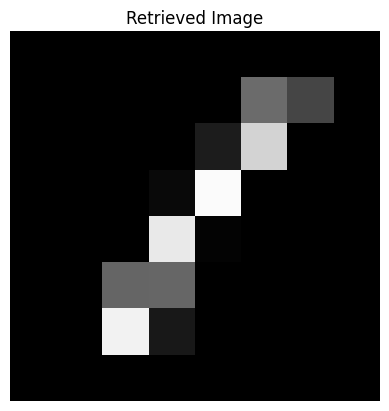

In [24]:
from collections import defaultdict
from qiskit import transpile
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

# 1) Transpile & run
simulator = AerSimulator()
t_qc = transpile(qc, simulator)
result = simulator.run(t_qc, shots=180).result()
counts = result.get_counts()

# 2) Build a dict: position → { intensity → votes }
pos2counts = defaultdict(lambda: defaultdict(int))
for bitstr, cnt in counts.items():
    # MSB-first: first 8 bits = intensity, last 6 bits = position
    intensity = int(bitstr[:8],  2)
    position  = int(bitstr[8:],   2)
    pos2counts[position][intensity] += cnt

# 3) Winner-takes-all decode
flat = np.zeros(64, dtype=int)
for pos, idict in pos2counts.items():
    # pick the intensity with the highest vote-count
    flat[pos] = max(idict.items(), key=lambda kv: kv[1])[0]

# 4) Reshape back to 8×8 and plot
retrieve_image = flat.reshape((8,8)).astype(np.uint8)
plt.imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
plt.title("Retrieved Image")
plt.axis('off')
plt.show()


In [25]:
from qiskit.quantum_info import Statevector, state_fidelity
import numpy as np

# 1) Flatten & normalize the original image
original_flat = image.flatten().astype(float)
orig_norm     = original_flat / np.linalg.norm(original_flat)

# 2) Flatten & normalize the retrieved image
retrieved_flat = retrieve_image.flatten().astype(float)
retrieved_norm = retrieved_flat / np.linalg.norm(retrieved_flat)

# 3) Build statevectors
original_state  = Statevector(orig_norm)
retrieved_state = Statevector(retrieved_norm)

# 4) Compute fidelity
fidelity = state_fidelity(original_state, retrieved_state)
print(f"Fidelity between original and retrieved images: {fidelity:.4f}")


Fidelity between original and retrieved images: 1.0000


Processing 100 shots...
  Image 0 with 100 shots...
  Image 1 with 100 shots...
  Image 2 with 100 shots...
  Image 3 with 100 shots...
  Image 4 with 100 shots...
  Image 5 with 100 shots...  Image 6 with 100 shots...

  Image 7 with 100 shots...
  Image 8 with 100 shots...
  Image 9 with 100 shots...
  Image 10 with 100 shots...
  Image 11 with 100 shots...
    -> Fidelity: 0.6428
  Image 12 with 100 shots...
    -> Fidelity: 0.8986
  Image 13 with 100 shots...
    -> Fidelity: 1.0000
    -> Fidelity: 0.9944
  Image 14 with 100 shots...
  Image 15 with 100 shots...
    -> Fidelity: 0.6368
  Image 16 with 100 shots...
    -> Fidelity: 0.6724
    -> Fidelity: 0.7124  Image 17 with 100 shots...

  Image 18 with 100 shots...    -> Fidelity: 0.8928

  Image 19 with 100 shots...
    -> Fidelity: 0.7982
    -> Fidelity: 0.7276
    -> Fidelity: 0.6740
    -> Fidelity: 0.6833
    -> Fidelity: 0.7123
    -> Fidelity: 0.5668
    -> Fidelity: 0.8079
    -> Fidelity: 0.3915
    -> Fidelity: 0.835

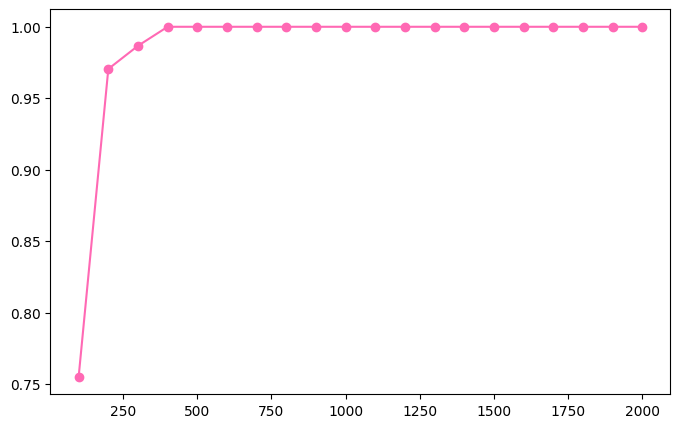

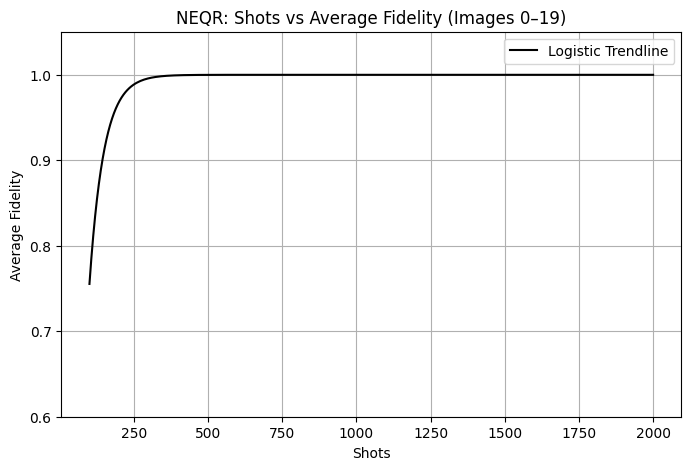

In [26]:
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, state_fidelity
import numpy as np
from collections import defaultdict
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from concurrent.futures import ThreadPoolExecutor

# Shots: every 100 from 100 to 2000
shot_counts = np.arange(100, 2001, 100)
num_images = 20  # Reduce for speed

def fidelity_for_image_args(args):
    img_idx, shots = args
    print(f"  Image {img_idx} with {shots} shots...", flush=True)
    # Load image
    image_data = dataset.to_numpy()[img_idx, 1:]
    image = image_data.reshape(8, 8).astype(np.uint8)
    pixel_values = image.flatten()

    # Build and encode circuit
    position_qubits = QuantumRegister(6, 'pos')
    intensity_qubits = QuantumRegister(8, 'int')
    classical_bits = ClassicalRegister(14, 'c')
    qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)
    neqr(qc, position_qubits, intensity_qubits, pixel_values)
    qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])

    # Simulate
    t_qc = transpile(qc, simulator)
    result = simulator.run(t_qc, shots=int(shots)).result()
    counts = result.get_counts()

    # Winner-takes-all decode
    pos2counts = defaultdict(lambda: defaultdict(int))
    for bitstr, cnt in counts.items():
        intensity = int(bitstr[:8],  2)
        position  = int(bitstr[8:], 2)
        pos2counts[position][intensity] += cnt

    flat = np.zeros(64, dtype=int)
    for pos, idict in pos2counts.items():
        flat[pos] = max(idict.items(), key=lambda kv: kv[1])[0]
    retrieved_image = flat.reshape((8,8)).astype(np.uint8)

    # Compute fidelity
    original_flat = image.flatten().astype(float)
    orig_norm     = original_flat / np.linalg.norm(original_flat)
    retrieved_flat = retrieved_image.flatten().astype(float)
    retrieved_norm = retrieved_flat / np.linalg.norm(retrieved_flat)
    original_state  = Statevector(orig_norm)
    retrieved_state = Statevector(retrieved_norm)
    fid = state_fidelity(original_state, retrieved_state)
    print(f"    -> Fidelity: {fid:.4f}", flush=True)
    return fid

fidelities = []

for shots in shot_counts:
    print(f"Processing {shots} shots...")
    args = [(img_idx, shots) for img_idx in range(num_images)]
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(fidelity_for_image_args, args))
    avg_fid = np.mean(results)
    fidelities.append(avg_fid)
    print(f"Shots: {shots}, Avg Fidelity: {avg_fid:.4f}")

# Plot
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

def logistic(x, L, x0, k, b):
    return L / (1 + np.exp(-k*(x-x0))) + b

plt.figure(figsize=(8,5))
plt.plot(shot_counts, fidelities, marker='o', color='hotpink', label='Average Fidelity')

# Plot only the smooth logistic trendline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

def logistic(x, L, x0, k, b):
    return L / (1 + np.exp(-k*(x-x0))) + b

p0 = [1, np.median(shot_counts), 0.01, 0]  # Initial guess
plt.figure(figsize=(8,5))
try:
    params, _ = curve_fit(logistic, shot_counts, fidelities, p0, maxfev=10000)
    x_fit = np.linspace(min(shot_counts), max(shot_counts), 300)
    plt.plot(x_fit, logistic(x_fit, *params), color='black', linestyle='-', label='Logistic Trendline')
except Exception as e:
    print("Logistic fit failed:", e)

plt.title(f"NEQR: Shots vs Average Fidelity (Images 0–{num_images-1})")
plt.xlabel("Shots")
plt.ylabel("Average Fidelity")
plt.grid(True)
plt.ylim(0.6, 1.05)
plt.legend()
plt.show()